# Capstone Project - The Battle of the Neighborhoods (Week 2)

##### Carlos Eduardo Bittencourt



### Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)


## Introduction: Business Problem <a name="introduction"></a>

Over the last years cycling has becoming increasingly popular as a transport method all over the world, and my city Porto Alegre, Brazil, is no exception.
While it is still mainly used for recreational purposes due to city shy advance in infrastructure it just keeps growing and so are the business oportunities.
The goal is to show that there is plenty of room for new business, but also this map could help guide for building new bike lanes or emergency units for this specificity.

## Data <a name="data"></a>

A list of Porto Alegre's neighborhood and some statistical information from wikipedia:
https://pt.wikipedia.org/wiki/Lista_de_bairros_de_Porto_Alegre

A dataset from the city administration, it is avaliable at http://datapoa.com.br/dataset/acidentes-de-transito-acidentes in a csv file. The website is in Portuguese.
It is actually a record of many types of traffic accidents, I filtered only the ones with bycicle (more than one thousand!) and from that I did the cycling flux map.

In [1]:
# import libraries

import pandas as pd 
import numpy as np 
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

import requests
import geocoder
from geopy.geocoders import Nominatim 
from IPython.display import Image 
from IPython.core.display import HTML 
from pandas.io.json import json_normalize
import folium 

from sklearn.cluster import KMeans
from sklearn import preprocessing

print('Libraries imported.')

Libraries imported.


In [2]:
# get the response in the form of html

wikiurl="https://pt.wikipedia.org/wiki/Lista_de_bairros_de_Porto_Alegre"
response=requests.get(wikiurl)
print(response.status_code, '...means ok!')

200 ...means ok!


In [3]:
#use BeautifulSoup to turn wikipage into a dataframe

soup = BeautifulSoup(response.text, 'html.parser')
can_postal_table = soup.find('table', {'class':"wikitable"})
df = pd.read_html(str(can_postal_table))
df = pd.DataFrame(df[0])
df.head()

,Bairro,Data de Criação,Área,População2010,Tx Cresc Pop 91-00,Densidade,Renda média por domicílio,Nota
0,Aberta dos Morros,21 dez 2015,NaN,NaN,NaN,NaN,NaN,NaN
1,Agronomia,21 set 1976,1241 ha,12222.0,"19,24% a.a.","8,6 hab/ha","3,98 SM/mês",(1)
2,Anchieta,7 dez 1959,84 ha,203.0,"0,51% a.a.","2,4 hab/ha","8,41 SM/mês",NaN
3,Arquipélago,7 dez 1959,4718 ha,5061.0,"9,32% a.a.","1,1 hab/ha","2,96 SM/mês",NaN
4,Auxiliadora,7 dez 1959,82 ha,9985.0,"-0,25% a.a.","121,8 hab/ha","19,57 SM/mês",NaN


In [4]:
# Shape the dataframe with only the necessary information

df.rename(columns={'Bairro':'Neighborhood', 'População2010':'Population', 'Renda média por domicílio':'Monthly Avg Income'}, inplace=True)
df.drop(['Data de Criação', 'Tx Cresc Pop 91-00', 'Densidade', 'Nota', 'Área'], axis=1, inplace=True)
df['Monthly Avg Income'] = df['Monthly Avg Income'].astype('str')
df['Monthly Avg Income'] = df['Monthly Avg Income'].apply(lambda x: x[:4])
df['Monthly Avg Income'] = (df['Monthly Avg Income'].str.split()).apply(lambda x: float(x[0].replace(',', '.')))
df = df[~df.Neighborhood.str.contains('TOTAL')]
df = df[df['Population'].notna()]
df = df[df['Monthly Avg Income'].notna()]
df.reset_index()

,index,Neighborhood,Population,Monthly Avg Income
0,1,Agronomia,12222.0,3.98
1,2,Anchieta,203.0,8.41
2,3,Arquipélago,5061.0,2.96
3,4,Auxiliadora,9985.0,19.50
4,5,Azenha,13449.0,10.70
...,...,...,...,...
74,90,Vila Conceição,1467.0,11.90
75,91,Vila Ipiranga,20951.0,8.99
76,92,Vila Jardim,14251.0,5.30
77,93,Vila João Pessoa,10522.0,5.58


In [5]:
df.head()

,Neighborhood,Population,Monthly Avg Income
1,Agronomia,12222.0,3.98
2,Anchieta,203.0,8.41
3,Arquipélago,5061.0,2.96
4,Auxiliadora,9985.0,19.50
5,Azenha,13449.0,10.70


In [6]:
# Get the neighborhoods coordinates

neighborhoods = df['Neighborhood'].to_list()

longitude = []
latitude = []

for neighborhood in neighborhoods:
    
    # initialize the variable to None
    lat_lng_coords = None

    # loop until getting the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Porto Alegre, Rio Grande do Sul'.format(neighborhood))
        lat_lng_coords = g.latlng

    
    # Append the data to the lists
    latitude.append(lat_lng_coords[0])
    longitude.append(lat_lng_coords[1])

In [7]:
poa_coord = pd.DataFrame({'Neighborhood': neighborhoods, 'Latitude': latitude, 'Longitude': longitude})
poa_coord.head()

,Neighborhood,Latitude,Longitude
0,Agronomia,-30.09137,-51.12186
1,Anchieta,-29.98371,-51.16616
2,Arquipélago,-29.99078,-51.23045
3,Auxiliadora,-30.01978,-51.18847
4,Azenha,-30.04896,-51.21540


In [8]:
# This the second data, for the bicycle flux in the city

df_traff = pd.read_csv('https://dadosabertos.poa.br/dataset/d6cfbe48-ee1f-450f-87f5-9426f6a09328/resource/b56f8123-716a-4893-9348-23945f1ea1b9/download/cat_acidentes.csvData', sep=';')
df_traff.head()

,data_extracao,idacidente,longitude,latitude,log1,log2,predial1,tipo_acid,queda_arr,data,...,caminhao,moto,carroca,bicicleta,outro,noite_dia,regiao,cont_vit,ups,consorcio
0,2020-12-01 01:33:39,190816,NaN,NaN,R MARCOS MOREIRA,R GASTON ENGLERT,0,ABALROAMENTO,0,2020-10-17 00:00:00,...,0,1,0,0,0,NOITE,NORTE,1,5,NaN
1,2020-12-01 01:33:39,601004,-51.146812,-30.151813,R ENG OSCAR DE OLIVEIRA RAMOS,NaN,4141,ABALROAMENTO,0,2015-01-02 00:00:00,...,0,0,0,0,1,NOITE,SUL,1,5,NaN
2,2020-12-01 01:33:39,601028,-51.232759,-30.037344,NaN,NaN,0,EVENTUAL,0,2015-01-02 00:00:00,...,0,0,0,0,0,DIA,CENTRO,0,1,NaN
3,2020-12-01 01:33:39,601080,-51.214493,-30.026976,R SANTO ANTONIO,NaN,215,COLISÃO,0,2015-01-05 00:00:00,...,0,0,0,0,0,DIA,CENTRO,0,1,NaN
4,2020-12-01 01:33:39,601111,-51.185210,-30.036497,R CARAZINHO,NaN,741,ABALROAMENTO,0,2015-01-04 00:00:00,...,0,1,0,0,0,DIA,NORTE,1,5,NaN


In [9]:
df_bike = df_traff[df_traff.bicicleta != 0]
df_bike.reset_index(drop=True, inplace=True)
df_bike.head()

,data_extracao,idacidente,longitude,latitude,log1,log2,predial1,tipo_acid,queda_arr,data,...,caminhao,moto,carroca,bicicleta,outro,noite_dia,regiao,cont_vit,ups,consorcio
0,2020-12-01 01:33:39,601251,-51.227888,-30.048904,AV PRAIA DE BELAS,NaN,1181,ABALROAMENTO,0,2015-01-11 00:00:00,...,0,0,0,1,0,NOITE,CENTRO,1,5,NaN
1,2020-12-01 01:33:39,601236,-51.148988,-30.067380,AV BENTO GONCALVES,NaN,6741,ABALROAMENTO,0,2015-01-09 00:00:00,...,0,1,0,1,0,NOITE,LESTE,1,5,NaN
2,2020-12-01 01:33:39,601112,-51.256198,-30.109581,R SARGENTO NICOLAU DIAS DE FARIAS,NaN,486,ABALROAMENTO,0,2015-01-05 00:00:00,...,0,0,0,1,0,NOITE,SUL,1,5,NaN
3,2020-12-01 01:33:39,601014,-51.233611,-30.105825,R DR PEREIRA NETO,R JOAO MORA,0,ABALROAMENTO,0,2015-01-04 00:00:00,...,0,1,0,1,0,DIA,SUL,1,5,NaN
4,2020-12-01 01:33:39,601215,-51.184114,-30.113348,R VENTURA PINTO,NaN,185,ABALROAMENTO,0,2015-01-07 00:00:00,...,0,0,0,1,0,DIA,SUL,1,5,NaN


In [10]:
df_bike.drop(['cont_vit', 'ups', 'consorcio', 'data_extracao', 'log1', 'log2', 'predial1', 'outro', 'noite_dia',
             'queda_arr', 'data', 'dia_sem', 'hora', 'feridos', 'feridos_gr', 'mortes', 'morte_post', 'fatais', 
              'auto', 'taxi', 'lotacao', 'onibus_urb', 'onibus_met', 'onibus_int', 'caminhao','moto', 'carroca', 'tipo_acid', 'bicicleta'],
             axis=1, inplace=True)
df_bike = df_bike[df_bike['longitude'].notna()]
df_bike = df_bike[df_bike['latitude'].notna()]
df_bike.reset_index(drop=True, inplace=True)

C:\Users\ceb_p\anaconda3\lib\site-packages\pandas\core\frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [11]:
# reducing its size a bit

df_bike = df_bike[0:300]
df_bike.reset_index(drop=True, inplace=True)
df_bike.rename(columns={'idacidente':'id', 'regiao':'borough'}, inplace=True)

In [12]:
# translating the column names
# the data has a good proportion

df_bike['borough'] = df_bike['borough'].str.replace('NORTE','North')
df_bike['borough'] = df_bike['borough'].str.replace('SUL','South')
df_bike['borough'] = df_bike['borough'].str.replace('LESTE','East')
df_bike['borough'] = df_bike['borough'].str.replace('CENTRO','Centre')
df_bike.groupby('borough').count()

,id,longitude,latitude
borough,,,
Centre,53,53,53
East,71,71,71
North,87,87,87
South,89,89,89


In [13]:
df_bike.head()

,id,longitude,latitude,borough
0,601251,-51.227888,-30.048904,Centre
1,601236,-51.148988,-30.067380,East
2,601112,-51.256198,-30.109581,South
3,601014,-51.233611,-30.105825,South
4,601215,-51.184114,-30.113348,South


## Methodology <a name="methodology"></a>

For this project I will look to areas of Porto Alegre with low bycicle shop density, if possible near to bike lanes,  and try to align it with economic and populational density aspects. We will look to all neighboors we had the proper data.

So I took a look at general aspects of the neighborhoods, mainly its population and average income. Then with FourSquare API made a list of all bycicle shops in Porto Alegre.
With that information I latter applied KClusters algorithm to map bycicle shops and neighborhood in one indicator (the clusters) and contrasted that with the map of bycicle flux and the map of actual bycle lanes.


### Data exploration

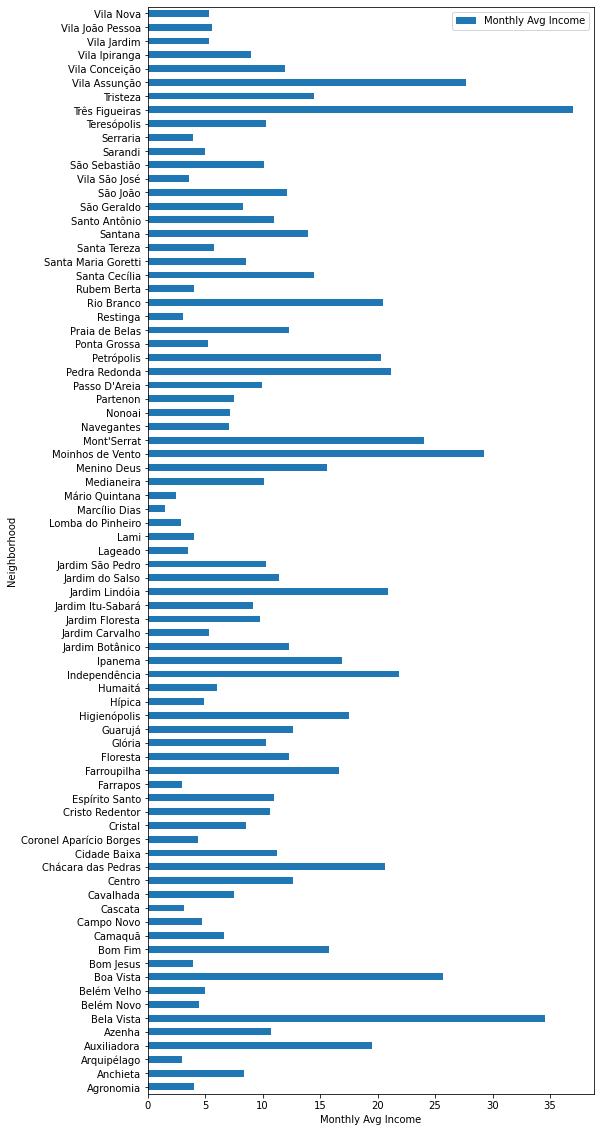

In [14]:
# Take the neighborhood dataframe to look at it's income average.
# It's income index is the minimum wage per month in Reais(R$), each unit is approximately U$ 204.00

df.plot(x='Neighborhood', y='Monthly Avg Income', kind='barh', figsize=(8,20))

plt.xlabel('Monthly Avg Income')
plt.ylabel('Neighborhood')

plt.show()

In [15]:
N5 = df['Monthly Avg Income'].groupby(df['Neighborhood']).sum().sort_values(ascending=False).head()
N5

Neighborhood
Três Figueiras      37.0
Bela Vista          34.6
Moinhos de Vento    29.3
Vila Assunção       27.7
Boa Vista           25.7
Name: Monthly Avg Income, dtype: float64

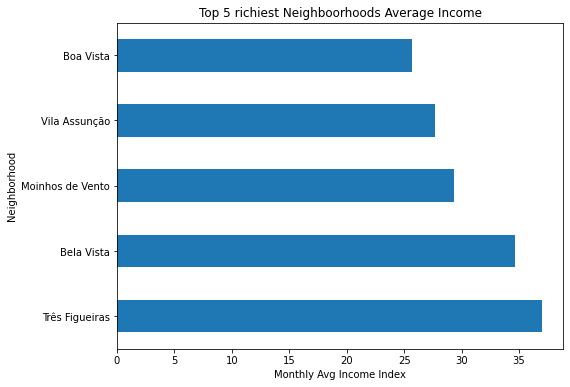

In [16]:
N5.plot(kind='barh', figsize=(8,6))

plt.title('Top 5 richiest Neighboorhoods Average Income')
plt.xlabel('Monthly Avg Income Index')
plt.ylabel('Neighborhood')

plt.show()

In [17]:
# Foursquare Credentials

CLIENT_ID = '1Z0POCBN35HT00UZRDHULNLIQWUMOORVEOEQ4CLQW52VGBDF' # your Foursquare ID
CLIENT_SECRET = 'DCNLFUDB30CNK5LRP3RMXRVGKPTGZEVMA3QGTLI5DQKDUIVY' # your Foursquare Secret
ACCESS_TOKEN = '3IYJYOFCZTDCDNYUCTHX5MFHBG0KIDP0JVGKDBLGZQACEVQD' # your FourSquare Access Token
VERSION = '20180605'

In [18]:
# Get the bikeshops list by neighborhood

def getNearbyVenues(names, latitudes, longitudes, radius=1500, LIMIT=300, categoryId='4bf58dd8d48988d115951735'):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            categoryId)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

venues = getNearbyVenues(names=poa_coord['Neighborhood'],
                                   latitudes=poa_coord['Latitude'],
                                   longitudes=poa_coord['Longitude']
                                  )

Agronomia
Anchieta
Arquipélago
Auxiliadora
Azenha
Bela Vista
Belém Novo
Belém Velho
Boa Vista
Bom Jesus
Bom Fim
Camaquã
Campo Novo
Cascata
Cavalhada
Centro
Chácara das Pedras
Cidade Baixa
Coronel Aparício Borges
Cristal
Cristo Redentor
Espírito Santo
Farrapos
Farroupilha
Floresta
Glória
Guarujá
Higienópolis
Hípica
Humaitá
Independência
Ipanema
Jardim Botânico
Jardim Carvalho
Jardim Floresta
Jardim Itu-Sabará
Jardim Lindóia
Jardim do Salso
Jardim São Pedro
Lageado
Lami
Lomba do Pinheiro
Marcílio Dias
Mário Quintana
Medianeira
Menino Deus
Moinhos de Vento
Mont'Serrat
Navegantes
Nonoai
Partenon
Passo D'Areia
Pedra Redonda
Petrópolis
Ponta Grossa
Praia de Belas
Restinga
Rio Branco
Rubem Berta
Santa Cecília
Santa Maria Goretti
Santa Tereza
Santana
Santo Antônio
São Geraldo
São João
Vila São José
São Sebastião
Sarandi
Serraria
Teresópolis
Três Figueiras
Tristeza
Vila Assunção
Vila Conceição
Vila Ipiranga
Vila Jardim
Vila João Pessoa
Vila Nova


In [19]:
# Removing motorbike shops

venues = venues[~venues.Venue.str.contains("Ducati", 'Bs Motos')]
venues = venues[~venues.Venue.str.contains('mototech')]
venues.reset_index(drop=True, inplace=True)
venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Auxiliadora,-30.01978,-51.18847,Espaço do Ciclista,-30.010239,-51.188943,Bike Shop
1,Auxiliadora,-30.01978,-51.18847,Gaúcha Bike ZN,-30.007717,-51.193079,Bike Shop
2,Auxiliadora,-30.01978,-51.18847,Velocity,-30.021953,-51.194049,Bike Shop
3,Auxiliadora,-30.01978,-51.18847,Biketech,-30.023465,-51.197879,Bike Shop
4,Auxiliadora,-30.01978,-51.18847,M. Bike,-30.015607,-51.196491,Bike Shop


In [20]:
venues.shape

(209, 7)

#### Pre-processing

In [21]:
df.head(2)

,Neighborhood,Population,Monthly Avg Income
1,Agronomia,12222.0,3.98
2,Anchieta,203.0,8.41


In [22]:
# Removing non numerical data

df_2 = df.drop('Neighborhood', axis=1)
df_2.head(2)

,Population,Monthly Avg Income
1,12222.0,3.98
2,203.0,8.41


In [23]:
# Pre-processing

from sklearn.preprocessing import StandardScaler

X = df_2.values
X = np.nan_to_num(X)
cluster_dataset = StandardScaler().fit_transform(X)
cluster_dataset[:5]

array([[-0.25485461, -0.9364534 ],
       [-1.09340799, -0.34890146],
       [-0.75447028, -1.07173624],
       [-0.41092782,  1.12196784],
       [-0.16924807, -0.04517822]])

#### Modeling

In [24]:
# Initialize the Cluster Algorithm

num_clusters = 6

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(cluster_dataset)
labels = k_means.labels_

print(labels)

[5 5 5 0 4 0 5 5 0 1 4 1 5 1 1 2 0 4 1 1 4 4 1 4 4 4 4 4 5 5 0 4 4 1 4 1 0
 4 4 5 5 1 5 1 4 2 0 0 5 1 3 1 0 2 5 4 3 0 3 4 5 3 2 4 5 4 1 4 3 5 4 0 4 0
 4 1 5 5 1]


In [25]:
# Take the label so we can identify the cluster on the map

df['Labels'] = labels
df.head()

,Neighborhood,Population,Monthly Avg Income,Labels
1,Agronomia,12222.0,3.98,5
2,Anchieta,203.0,8.41,5
3,Arquipélago,5061.0,2.96,5
4,Auxiliadora,9985.0,19.50,0
5,Azenha,13449.0,10.70,4


In [26]:
# Merge the dataframes to have all the needed information more easily

venues_merged = df.join(venues.set_index('Neighborhood'), on='Neighborhood')
venues_merged.head() 

,Neighborhood,Population,Monthly Avg Income,Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,Agronomia,12222.0,3.98,5,NaN,NaN,NaN,NaN,NaN,NaN
2,Anchieta,203.0,8.41,5,NaN,NaN,NaN,NaN,NaN,NaN
3,Arquipélago,5061.0,2.96,5,NaN,NaN,NaN,NaN,NaN,NaN
4,Auxiliadora,9985.0,19.50,0,-30.01978,-51.18847,Espaço do Ciclista,-30.010239,-51.188943,Bike Shop
4,Auxiliadora,9985.0,19.50,0,-30.01978,-51.18847,Gaúcha Bike ZN,-30.007717,-51.193079,Bike Shop


In [27]:
venues_merged = venues_merged[venues_merged['Neighborhood Latitude'].notna()]
venues_merged = venues_merged[venues_merged['Neighborhood Longitude'].notna()]
venues_merged = venues_merged[venues_merged['Venue'].notna()]
venues_merged = venues_merged[venues_merged['Venue Latitude'].notna()]
venues_merged = venues_merged[venues_merged['Venue Longitude'].notna()]
venues_merged = venues_merged[venues_merged['Venue Category'].notna()]
venues_merged = venues_merged[venues_merged['Labels'].notna()]

In [28]:
venues_merged['Labels'] = venues_merged['Labels'].apply(lambda x: int(x))
venues_merged.reset_index(drop=True)

,Neighborhood,Population,Monthly Avg Income,Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Auxiliadora,9985.0,19.50,0,-30.01978,-51.18847,Espaço do Ciclista,-30.010239,-51.188943,Bike Shop
1,Auxiliadora,9985.0,19.50,0,-30.01978,-51.18847,Gaúcha Bike ZN,-30.007717,-51.193079,Bike Shop
2,Auxiliadora,9985.0,19.50,0,-30.01978,-51.18847,Velocity,-30.021953,-51.194049,Bike Shop
3,Auxiliadora,9985.0,19.50,0,-30.01978,-51.18847,Biketech,-30.023465,-51.197879,Bike Shop
4,Auxiliadora,9985.0,19.50,0,-30.01978,-51.18847,M. Bike,-30.015607,-51.196491,Bike Shop
...,...,...,...,...,...,...,...,...,...,...
204,Vila Jardim,14251.0,5.30,5,-30.03298,-51.14992,Casa das Bicicletas,-30.040904,-51.158022,Bike Shop
205,Vila Jardim,14251.0,5.30,5,-30.03298,-51.14992,Studio Motos,-30.040527,-51.160467,Bike Shop
206,Vila Jardim,14251.0,5.30,5,-30.03298,-51.14992,Cia do Ciclista,-30.044287,-51.141983,Bike Shop
207,Vila João Pessoa,10522.0,5.58,5,-30.06967,-51.17551,Bs Motos,-30.064282,-51.179932,Bike Shop


In [29]:
venues_merged.head()

,Neighborhood,Population,Monthly Avg Income,Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
4,Auxiliadora,9985.0,19.5,0,-30.01978,-51.18847,Espaço do Ciclista,-30.010239,-51.188943,Bike Shop
4,Auxiliadora,9985.0,19.5,0,-30.01978,-51.18847,Gaúcha Bike ZN,-30.007717,-51.193079,Bike Shop
4,Auxiliadora,9985.0,19.5,0,-30.01978,-51.18847,Velocity,-30.021953,-51.194049,Bike Shop
4,Auxiliadora,9985.0,19.5,0,-30.01978,-51.18847,Biketech,-30.023465,-51.197879,Bike Shop
4,Auxiliadora,9985.0,19.5,0,-30.01978,-51.18847,M. Bike,-30.015607,-51.196491,Bike Shop


In [30]:
# Get the coordinates

address = 'Porto Alegre, RS'

geolocator = Nominatim(user_agent="poa_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

-30.0324999 -51.2303767


In [31]:
# Creating the map of bikeshop/neighborhood clusters

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(num_clusters)
ys = [i + x + (i*x)**2 for i in range(num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(venues_merged['Venue Latitude'], venues_merged['Venue Longitude'], venues_merged['Neighborhood'], venues_merged['Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [32]:
# Now contrasting it with the bicycle flux of the city

map_clusters_flux = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(num_clusters)
ys = [i + x + (i*x)**2 for i in range(num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(venues_merged['Venue Latitude'], venues_merged['Venue Longitude'], venues_merged['Neighborhood'], venues_merged['Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_flux)
      
for lat, lng, borough in zip(df_bike['latitude'], df_bike['longitude'], df_bike['borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=0.8,
        popup=label,
        color='black',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters_flux)  
    
map_clusters_flux

## Results and Discussion <a name="results"></a>

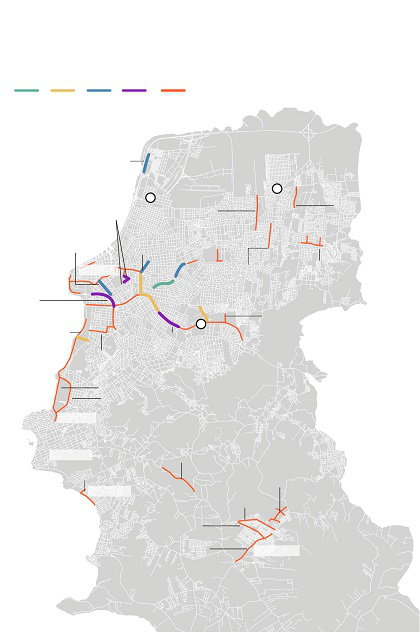

Map of current bycicle lanes in Porto Alegre, Brazil


In [33]:
from IPython.display import display
from PIL import Image

path="ciclovias-Artboard_1.jpg"
display(Image.open(path))
print('Map of current bycicle lanes in Porto Alegre, Brazil')

There is a clear alignment between the cyclist flux and the location of bikeshops in the city, specially in the zone between North and South of city, but is also clear that there are spaces with potencial for new busines that happen with economic and social dinamics, like São Geraldo and Floresta which were almost abandoned neighborhoods and now are trend, with new places, buildings, young people and also with a better terrain for cycling. Also the bay area of the city is getting refreshed by new spaces, getting increasingly higher number of visitors, tourists, and spaces to buy or rent bikes.

The clusters show that neighborhoods of contrasting income profile and population density are very near each other, so finding the perfect spot for a new business can be quite a challenge, specially if you consider the dinamics of the changes in the city.

When opening new business and solutions there are many complex aspects to consider, so I made quite a simplification just to show how the tools of Data Science with Python can help achieve sharper solutions; with that in mind I made 3 sugetions of places where it can be done.

In [34]:
# Making a black circle around the suggested areas and removing the flux dots for cleaner visual.

map_final = folium.Map(location=[latitude, longitude], zoom_start=13)

folium.CircleMarker(
    [-30.018086745728123, -51.20769468412793],
    radius=15,
    color='black',
    popup='Suggestion 1',
    fill = True,
    fill_color = 'white',
    fill_opacity = 0.5
    ).add_to(map_final)

folium.CircleMarker(
    [-30.033272133840505, -51.18851022142575],
    radius=15,
    color='black',
    popup='Suggestion 3',
    fill = True,
    fill_color = 'white',
    fill_opacity = 0.5
    ).add_to(map_final)

folium.CircleMarker(
    [-30.006534151285326, -51.17552502154391],
    radius=15,
    color='black',
    popup='Suggestion 2',
    fill = True,
    fill_color = 'white',
    fill_opacity = 0.6
    ).add_to(map_final)       

# set color scheme for the clusters
x = np.arange(num_clusters)
ys = [i + x + (i*x)**2 for i in range(num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]  

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(venues_merged['Venue Latitude'], venues_merged['Venue Longitude'], venues_merged['Neighborhood'], venues_merged['Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_final)

map_final

Selecionar tres areas para sugestão


#### Suggestion 1: Floresta

A revigorated neighborhood, near one of the richiest neighborhood (Moinhos de Vento), has a high flux of cyclists, also it is near the bay area which is the postal card of the city.  

#### Suggestion 2: Santa Maria Goretti

It is better suited to a more midrange profile, but the north of the city is highly populated, has most of the city industries and flat streets, with plenty of potential for bycicle lanes.

#### Suggestion 1: Bela Vista

This area is like a cluster of rich neighborhoods. Though a high part of town, it has room for high profile shops. The bikelanes are still shy, but people there would love more.

## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify Porto Alegre areas with low number of bikeshops and with high potential for cycling, in order to aid stakeholders in narrowing down the search for optimal location for a new shop.  Clustering of those locations was then performed in order to create major zones of interest (containing greatest number of potential locations) and addresses of those zone centers were created to be used as starting points for final exploration by stakeholders.

Final decission on optimal bikeshop location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location (proximity to park or water), levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.